In [1]:
!pip3 install scikit-learn
!pip3 install torch
!pip3 install torchinfo


In [2]:
!pip3 install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection, InstanceHardnessThreshold, NearMiss, ClusterCentroids
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns


c:\Source\Anaconda\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
'''CONFIG FOR LOCAL / CLOUD RUNNING'''
running_local = 'content' not in os.getcwd()
if running_local:
    path = ''
else:
    from google.colab import drive
    drive.mount('/content/drive')
    path = 'drive/MyDrive/StructuralBioinformatics/'

In [4]:
# RUN ONLY TO REBUILD DATASET CSV
#dfs = []
#for filename in os.listdir('features_ring'):
#    if filename[-4:] == '.tsv':
#        dfs.append(pd.read_csv('features_ring/' + filename, sep='\t'))
#df = pd.concat(dfs)
#df

In [5]:
# don't need to execute - only to export df for training in cloud
#df.to_csv('contact_df.csv')

In [24]:
df = pd.read_csv(path + 'data/contact_df.csv')
df.dropna(inplace=True)

# Define ground truth values
y = df['Interaction'].astype('category')
y_oneHot = pd.get_dummies(y)
cat_names = list(y.cat.categories)
y


0               VDW
1             HBOND
2             HBOND
3         PIPISTACK
4             HBOND
            ...    
454188          VDW
454189        HBOND
454190          VDW
454191        HBOND
454192        HBOND
Name: Interaction, Length: 454193, dtype: category
Categories (6, object): ['HBOND', 'IONIC', 'PICATION', 'PIPISTACK', 'SSBOND', 'VDW']

In [10]:
# Define training features
X = df[['s_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
        't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]

#is this working?
X = X.fillna({col: X[col].mode()[0] for col in X.columns})

print("Scaling data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns=X.columns) #why are we casting it to a DF?
X_scaled = np.array(X_scaled) #undersampler and oversampler expects arrays
y_oneHot = np.array(y_oneHot) #undersampler and oversampler expects arrays


print("Undersampling data...")
undersample = InstanceHardnessThreshold(estimator=AdaBoostClassifier(),sampling_strategy={0:50000,5:50000})
X_scaled_SMOTE, y_oneHot_SMOTE = undersample.fit_resample(X_scaled, y_oneHot)

print("Oversampling data...")
oversample = SMOTE(sampling_strategy={1:50000,3:50000,2:50000,4:50000})
X_scaled_SMOTE, y_oneHot_SMOTE = oversample.fit_resample(X_scaled_SMOTE, y_oneHot_SMOTE)

X_scaled_SMOTE
y_oneHot_SMOTE


Scaling data...
Undersampling data...
Oversampling data...


array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]])

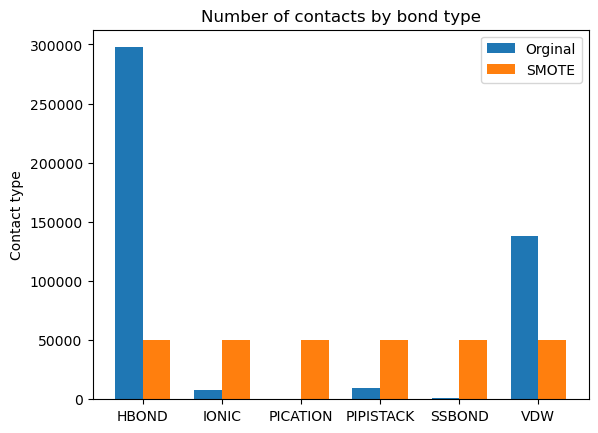

In [31]:
y_arg = np.argmax(y_oneHot.values, axis=1)
y_arg_SMOTE = np.argmax(y_oneHot_SMOTE.values, axis=1)
_, count = np.unique(y_arg, return_counts=True)
class_count = dict(zip(cat_names, count))
_, count_SMOTE = np.unique(y_arg_SMOTE, return_counts=True)
class_count_SMOTE = dict(zip(cat_names, count_SMOTE))

fig, ax = plt.subplots()
x = np.arange(len(cat_names))  # label locations
width = 0.35  # width of the bars
rects1 = ax.bar(x - width/2, count, width, label='Orginal')
rects2 = ax.bar(x + width/2, count_SMOTE, width, label='SMOTE')

# Add labels, title, and legend
ax.set_ylabel('Examples')
ax.set_ylabel('Contact type')
ax.set_title('Number of contacts by bond type')
ax.set_xticks(x)
ax.set_xticklabels(cat_names)
ax.legend()

plt.show()

In [35]:
X_scaled_SMOTE = pd.DataFrame(X_scaled_SMOTE, columns=X.columns)
y_oneHot_SMOTE = pd.DataFrame(y_oneHot_SMOTE)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_SMOTE, y_oneHot_SMOTE, test_size=0.1, random_state=0)

n_splits=10
kf = KFold(n_splits=n_splits, shuffle=True)

In [37]:
class ContactNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
        super().__init__()
        self.layers = nn.ModuleList()
        if len(hidden_layers_dim) == 0:
            self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
        else:
            for layer_idx in range(len(hidden_layers_dim)):
                if layer_idx == 0:  # first layer, from input to hidden
                    self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
                else:  # hidden layers, depending on the input
                    self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
            self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=.1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        if x.dtype != torch.float32:
            x = x.float()
        if len(self.layers) == 1:
            return self.layers[0](x)
        else:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
        return F.log_softmax(x, dim=1)#self.layers[-1](x)

input_size = X.shape[1]  # The number of input features
num_classes = y_oneHot.shape[1] # The number of output classes

model = ContactNet(input_size, num_classes, [60, 60, 128, 128, 128, 128, 256, 256, 256, 256])

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model)

Layer (type:depth-idx)                   Param #
ContactNet                               --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       1,260
│    └─Linear: 2-2                       3,660
│    └─Linear: 2-3                       7,808
│    └─Linear: 2-4                       16,512
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       33,024
│    └─Linear: 2-8                       65,792
│    └─Linear: 2-9                       65,792
│    └─Linear: 2-10                      65,792
│    └─Linear: 2-11                      1,542
Total params: 294,206
Trainable params: 294,206
Non-trainable params: 0

In [38]:
class EarlyStopping:
    def __init__(self, tolerance, min_delta):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if abs(validation_loss - train_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True


def train(model, optimizer, num_epochs):
    early_stopping = EarlyStopping(tolerance=10, min_delta=0.01) # slow to learn, so it has to be VERY tolerant

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    current_fold_counter=0

    for train_index, val_index in kf.split(X_train):

        current_fold_counter += 1

        early_stopping.early_stop = False
        early_stopping.counter = 0

        X_train_fold = X_train.values[train_index] #X_train (type np.ndarray) does not have any attribute called .values. Recasted to a pd.DataFrame but shouldn't be better to use a np.ndarray?
        y_train_fold = y_train.values[train_index]
        X_val_fold = X_train.values[val_index]
        y_val_fold = y_train.values[val_index]

        for epoch in range(num_epochs):
            out = model(torch.tensor(X_train_fold))
            y_train_fold_labels = np.argmax(y_train_fold, axis=1)
            loss = criterion(out, torch.tensor(y_train_fold_labels).long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
              val_outputs = model(X_val_fold)
              y_val_fold_labels = np.argmax(y_val_fold, axis=1)
              val_loss =  criterion(val_outputs, torch.tensor(y_val_fold_labels).long())
              _, val_preds = torch.max(val_outputs, 1)
              val_accuracy = accuracy_score(y_val_fold_labels, val_preds)
              train_accuracy = accuracy_score(y_train_fold_labels, torch.argmax(out, 1))


            print(f'Fold: #{current_fold_counter}/{n_splits} - Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {loss.item()} - Validation Loss: {val_loss.item()} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}')

            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)


            # Check for early stopping
            #early_stopping(loss.item(), val_loss.item())
            #if early_stopping.early_stop:
            #    print('Early stopping triggered...')
            #    break

        #if early_stopping.early_stop:
        #    break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [30]:
EPOCHS = 50

train_loss, val_loss, train_accuracy, val_accuracy = train(model, optimizer, num_epochs=EPOCHS)

Epoch 1/50 :
Train Loss: 5.535951614379883 - Validation Loss: 5.444551467895508 - Train Accuracy: 0.0 - Validation Accuracy: 0.0007389344565137073
Epoch 2/50 :
Train Loss: 5.444034099578857 - Validation Loss: 5.316451072692871 - Train Accuracy: 0.0006609520994466066 - Validation Accuracy: 0.12354984112909186
Epoch 3/50 :
Train Loss: 5.315589427947998 - Validation Loss: 5.117056846618652 - Train Accuracy: 0.12347898911276417 - Validation Accuracy: 0.17409295795462942
Epoch 4/50 :
Train Loss: 5.116089820861816 - Validation Loss: 4.813194274902344 - Train Accuracy: 0.1722950227433207 - Validation Accuracy: 0.16792285524273998
Epoch 5/50 :
Train Loss: 4.812159061431885 - Validation Loss: 4.375351905822754 - Train Accuracy: 0.16622329507200684 - Validation Accuracy: 0.16792285524273998
Epoch 6/50 :
Train Loss: 4.374324798583984 - Validation Loss: 3.7962634563446045 - Train Accuracy: 0.16622329507200684 - Validation Accuracy: 0.16792285524273998
Epoch 7/50 :
Train Loss: 3.795619249343872 - V

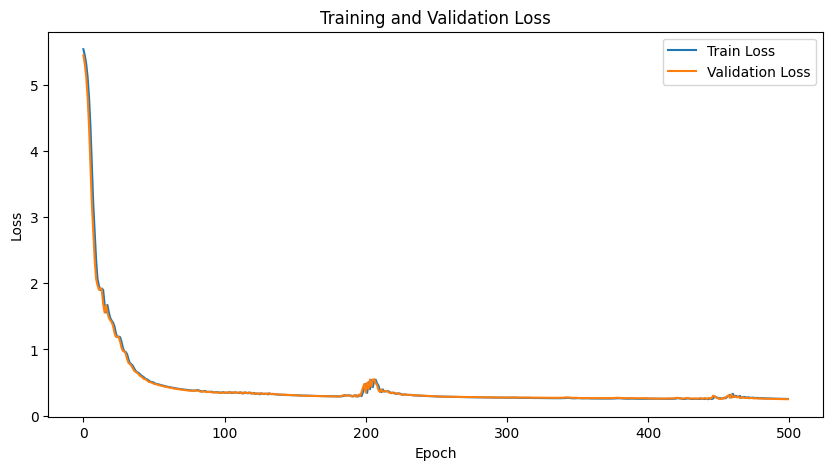

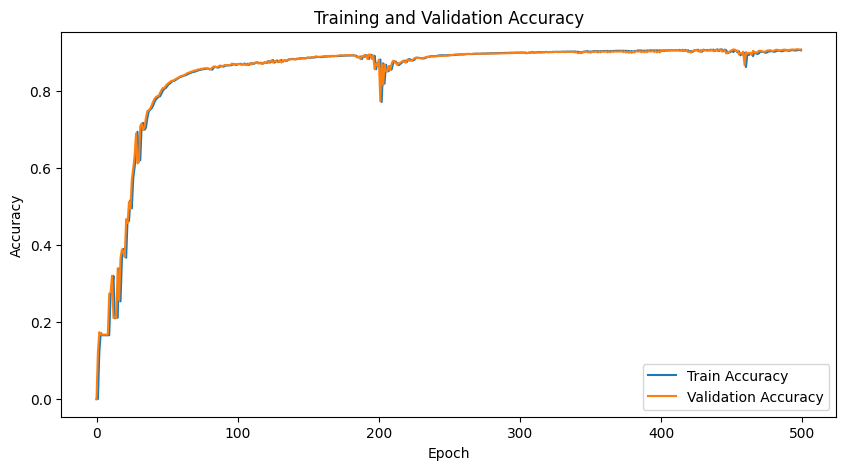

In [31]:


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [39]:

if running_local:
    PATH = "model/model.pth"
else:
    PATH = "drive/MyDrive/StructuralBioinformatics/model/model.pth"

In [35]:
torch.save(model, PATH)

In [40]:
# Load Model For Inference

model = torch.load(PATH)
model.eval()

ContactNet(
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [41]:
# Convert your test dataset into PyTorch tensors
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values).long()

# Create a DataLoader for your test set
test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=32)

In [42]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)

        # Get predicted class indices
        _, preds = torch.max(outputs, 1)
        
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

y_pred_oneHot = pd.get_dummies(y_pred).values
print(classification_report(y_true, y_pred_oneHot, target_names = cat_names))

              precision    recall  f1-score   support

       HBOND       0.79      0.90      0.84      5053
       IONIC       0.90      0.99      0.95      4971
    PICATION       0.93      1.00      0.96      5009
   PIPISTACK       0.98      1.00      0.99      5037
      SSBOND       0.98      1.00      0.99      4881
         VDW       0.87      0.57      0.69      5070

   micro avg       0.91      0.91      0.91     30021
   macro avg       0.91      0.91      0.90     30021
weighted avg       0.91      0.91      0.90     30021
 samples avg       0.91      0.91      0.91     30021



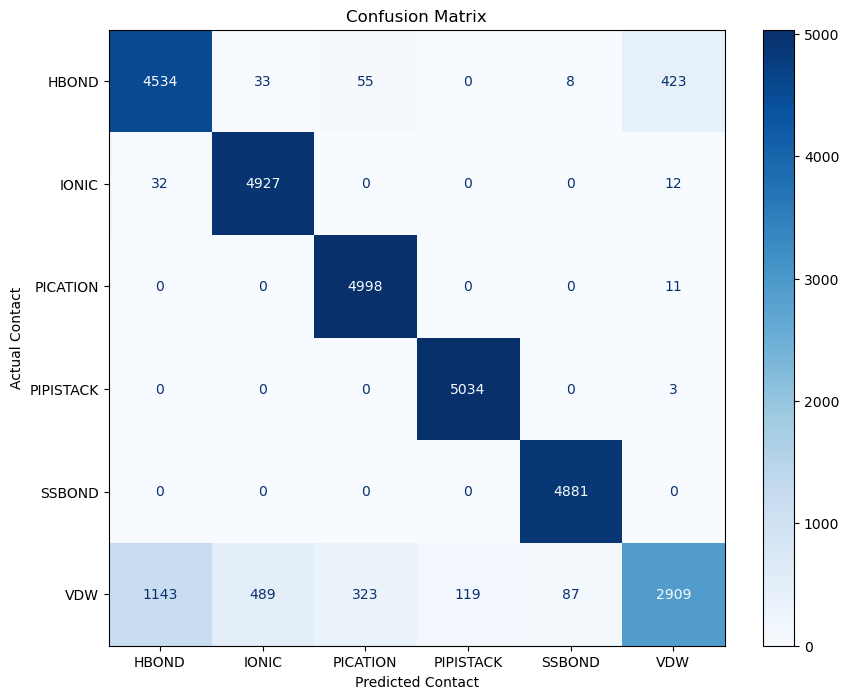

In [43]:
cm = confusion_matrix(np.argmax(y_true,axis=1), y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_names)
cm_display.plot(cmap='Blues', ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Actual Contact')
plt.xlabel('Predicted Contact')
plt.show()